# Predicting the Amount of Train Users using Machine Learning

In this notebook, I'm going to go through an example machine learning project with the goal of predicting the Amount of Train Users.

## 1. Problem Defintion

> They are considering making an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! While JetRail has mastered the technology and they hold the patent for their product, the investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months.
 
>You need to help Unicorn ventures with the decision. They usually invest in B2C start-ups less than 4 years old looking for pre-series A funding. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file.


## 2. Data

>The data is downloaded from the Analytics Vidhya Time Series Forcasting competition:https://datahack.analyticsvidhya.com>/contest/practice-problem-time-series-2/#ProblemStatement

There are 2 main datasets:

>* Train.csv is the training set, which contains ID, Date&Time Data and the count of People on the train.
>* Test.csv is the test set, is also of the same data but without the count column. The score on the test set determines the final rank for the competition.

>We have 18288 different records for the count of passengers in the train set and 5112 for the test set
    

## 3. Evaluation

>The evaluation metric for this competition is the Root Mean Squre Error (RMSE) between the actual and predicted count of users.

>For more on the evaluation on this project check: https://datahack.analyticsvidhya.com/contest/practice-problem-time-series-2/#ProblemStatement

> Note: The goal for most regression evaluation metrics is to minimise the error. For example, my goal for this project will be to build a machine learning model which minimise RMSE.
    

## 4. Features

Analytics Vidhya provides datasets detailing all of the features of the dataset. You can view this https://datahack.analyticsvidhya.com/contest/practice-problem-time-series-2/
>* ID is the unique number given to each observation point.
>* Datetime is the time of each observation.
>* Count is the passenger count corresponding to each Datetime.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
%matplotlib inline

In [2]:
# Read in the data
df_train = pd.read_csv("data/Train_SU63ISt.csv")
df_test = pd.read_csv("data/Test_0qrQsBZ.csv")

In [3]:
# Make copies of the datasets, have a original copy to refer back to.
train_original = df_train.copy()
test_original = df_test.copy()

### Explore Data Structure and Content

In [17]:
df_train.columns, df_test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [18]:
df_train.dtypes, df_test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object,
 ID           int64
 Datetime    object
 dtype: object)

In [19]:
df_train.shape, df_test.shape

((18288, 3), (5112, 2))

## Feature Extraction

In [4]:
# Convert the Datetime column from Object to Datetime, to allow us to extract features from it
df_train["Datetime"] = pd.to_datetime(df_train["Datetime"], format="%d-%m-%Y %H:%M")
df_test["Datetime"] = pd.to_datetime(df_test["Datetime"], format="%d-%m-%Y %H:%M")

train_original["Datetime"] = pd.to_datetime(train_original["Datetime"], format="%d-%m-%Y %H:%M")
test_original["Datetime"] = pd.to_datetime(test_original["Datetime"], format="%d-%m-%Y %H:%M")

In [5]:
# Extract features from Datetime
for i in (df_train,df_test,train_original,test_original):
    i["year"] = i["Datetime"].dt.year
    i["month"] = i["Datetime"].dt.month
    i["day"] = i["Datetime"].dt.day
    i["hour"] = i["Datetime"].dt.hour

In [6]:
# Extract day of week so we can anaylse if it was a weekend or weekday
df_train["day of week"] = df_train["Datetime"].dt.dayofweek
temp = df_train["Datetime"]

In [7]:
# Assign 1 if the day of week is a weekend and 0 if the day of week is not a weekend
def assign_dayofweek(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = df_train["Datetime"].apply(assign_dayofweek)
df_train["weekend"]=temp2

In [8]:
# View Dataframe to check the function has add a weekend column 
df_train.head()

,ID,Datetime,Count,year,month,day,hour,day of week,weekend
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5,1
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5,1


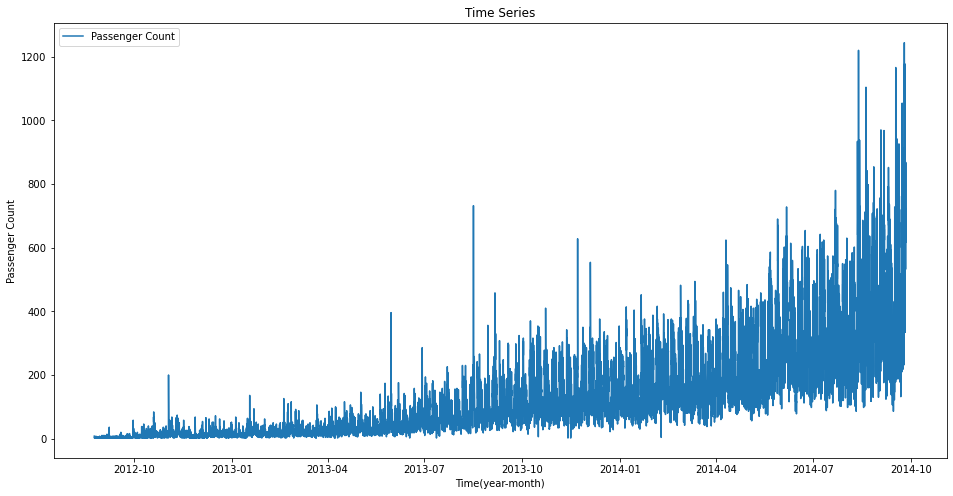

In [8]:
# Visualize the time series
df_train.index = df_train["Datetime"] # indexing the Datetime to get the time period on the x-axis
df = df_train.drop("ID",axis=1) # drop ID variable to get only the Datetime on the x-axis

ts = df["Count"]
plt.figure(figsize=(16,8))
plt.plot(ts, label="Passenger Count")
plt.title("Time Series")
plt.xlabel("Time(year-month)")
plt.ylabel("Passenger Count")
plt.legend(loc="best");

From the graph above I can infer that there is an increasing trend in the series, the number of count is increasing with respect to time. Certain points there is a sudden increase in the number of counts. The possible reason behind this could be that on a particular day, due to event traffic was high.

### The hypothesis that we made was:
   1. Traffic will increase as the years pass by.
   2. Traffic will be high from May to October.
   3. Traffic on weekends will be more.
   4. Traffic during peak hours will be high.

Now I have looked at the dataset I can now try and validate the hypothesis and make other inferences from the data

## Exploratory Analysis

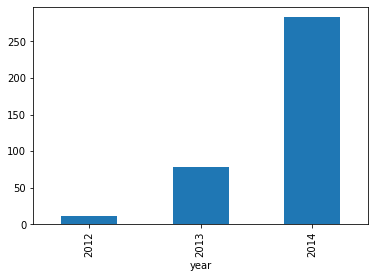

In [10]:
# First hypothesis was traffic will increase as the years pass, so I will look at that. Can see the growth year on year.
df_train.groupby("year")["Count"].mean().plot.bar();

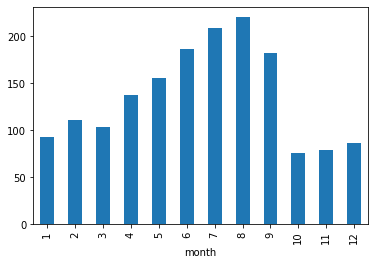

In [22]:
# Secondly traffic increase May to October
df_train.groupby("month")["Count"].mean().plot.bar();

Can see a decrease is the mean passenger count in the last three months of the year. This doesn't look right. Look at the monthly mean average for each year.

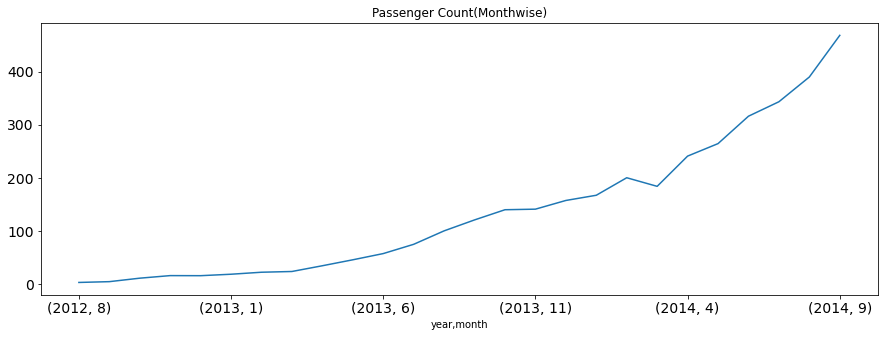

In [9]:
temp = df_train.groupby(["year", "month"])["Count"].mean()
temp.plot(figsize=(15,5), title="Passenger Count(Monthwise)",fontsize=14);

* The plot shows there are no months 10,11 and 12 for 2014 and the mean value for these months in 2012 is very less.

* Since there is an increasing trend in the time series, the mean value for the rest of the months will be more because of their larger passenger counts in year 2014 and we will get smaller value for these 3 months

* The above also shows an increase line plot in monthly passenger count and the growth is appox exponential.

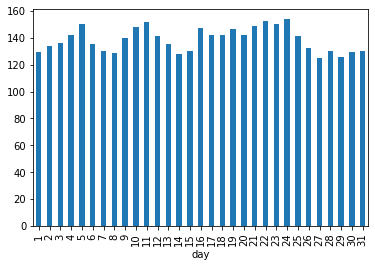

In [24]:
# Look at the daily mean of passenger count 
df_train.groupby("day")["Count"].mean().plot.bar();

The above plot does not really tell me much, so I will look at hourly count to find the peak hours

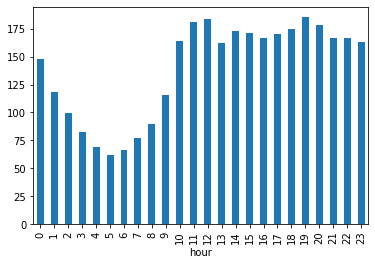

In [25]:
df_train.groupby("hour")["Count"].mean().plot.bar();

I can draw some insight from this plot:
1. Peak traffic starts at 7PM, there is a decreasing trend until 5AM.
2. After the count start increasing again, it hits peak at 11AM and 12 Noon

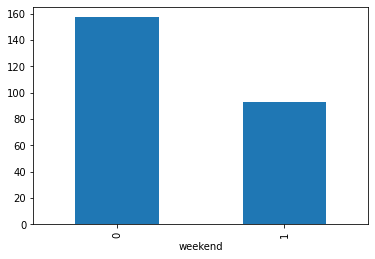

In [27]:
# Is are hypothesis right, is it busier on weekdays?
df_train.groupby("weekend")["Count"].mean().plot.bar();

Yes, it is correct there is more traffic on a weekday than a weekend

Look at this further and see count day wise

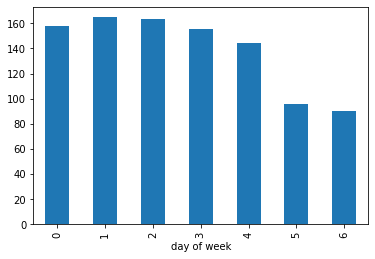

In [28]:
df_train.groupby("day of week")["Count"].mean().plot.bar();

In [14]:
df_train.head()

,ID,Datetime,Count,year,month,day,hour,day of week,weekend
Datetime,,,,,,,,,
2012-08-25 00:00:00,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1
2012-08-25 01:00:00,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2012-08-25 02:00:00,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1
2012-08-25 03:00:00,3,2012-08-25 03:00:00,2,2012,8,25,3,5,1
2012-08-25 04:00:00,4,2012-08-25 04:00:00,2,2012,8,25,4,5,1


### I can now start to look at preprocessing the data to prepare it for modelling

In [10]:
# Drop ID column as it has nothing to do with the Count.
df_train = df_train.drop("ID",axis=1)

There is a lot of noise in the hourly time series, I will aggregate the hourly time series to daily, weekly and monthly time series to reduce the noise and make it more stable and hence would be easier for the model to learn

In [11]:
df_train["Timestamp"] = pd.to_datetime(df_train["Datetime"],format = "%d-%m-%Y %H:%M")
df_train.index = df_train["Timestamp"]

# Hourly time series
hourly = df_train.resample("H").mean()
# Converting to daily mean
daily = df_train.resample("D").mean()
# Converting to weekly mean
weekly = df_train.resample("W").mean()
# Converting to monthly mean
monthly = df_train.resample("M").mean()

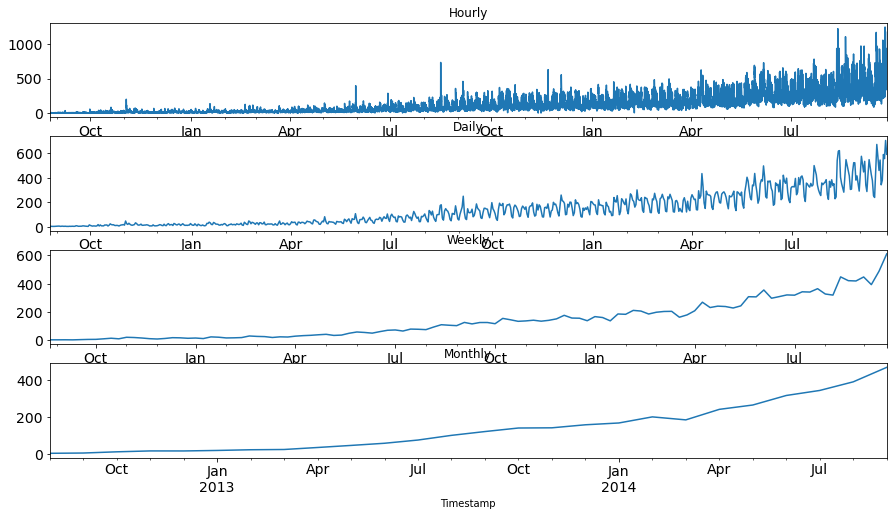

In [12]:
fig, axes = plt.subplots(4,1)
hourly["Count"].plot(figsize=(15,8), title="Hourly", fontsize=14, ax=axes[0]);
daily["Count"].plot(figsize=(15,8), title="Daily", fontsize=14, ax=axes[1]);
weekly["Count"].plot(figsize=(15,8), title="Weekly", fontsize=14, ax=axes[2]);
monthly["Count"].plot(figsize=(15,8), title="Monthly", fontsize=14, ax=axes[3]);

The time series now is becoming more stable aggregated on daily, weekly and monthly.

Would become to difficult to convert monthly and weekly predictions to hourly predictions. So I will work on daily time series

In [13]:
df_test["Timestamp"] = pd.to_datetime(df_test["Datetime"], format="%d-%m-%Y %H:%M")
df_test.index = df_test["Timestamp"]

# Converting to daily mean 
df_test = df_test.resample("D").mean()

df_train["Timestamp"] = pd.to_datetime(df_train["Datetime"], format="%d-%m-%Y %H:%M")
df_train.index = df_train["Timestamp"]

# Converting to daily mean 
df_train = df_train.resample("D").mean()

In [19]:
df_train.head()

,Count,year,month,day,hour,day of week,weekend
Timestamp,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0


In [14]:
# Slicing using the ix function to create a train and validation set to model and test with.
train_set = df_train.loc["2012-08-25":"2014-06-24"]
valid_set = df_train.loc["2014-06-25":"2014-09-25"]

In [17]:
train_set.shape, valid_set.shape

((669, 7), (93, 7))

In [26]:
train_set.head()

,Count,year,month,day,hour,day of week,weekend
Timestamp,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0


I have done time based validation(splitting) here, by selecting the last 3 months for the validation set and the rest for the training set. If, done randomly may have worked well for the training set but not the validation dataset.

Understand it better:
>If I chose the plit randomly it will take some values from the starting and some from last years as well. It is similar to predicting the old values based on the future values which is not the case in real scenario. So, this kind of split is used while working with time related problems

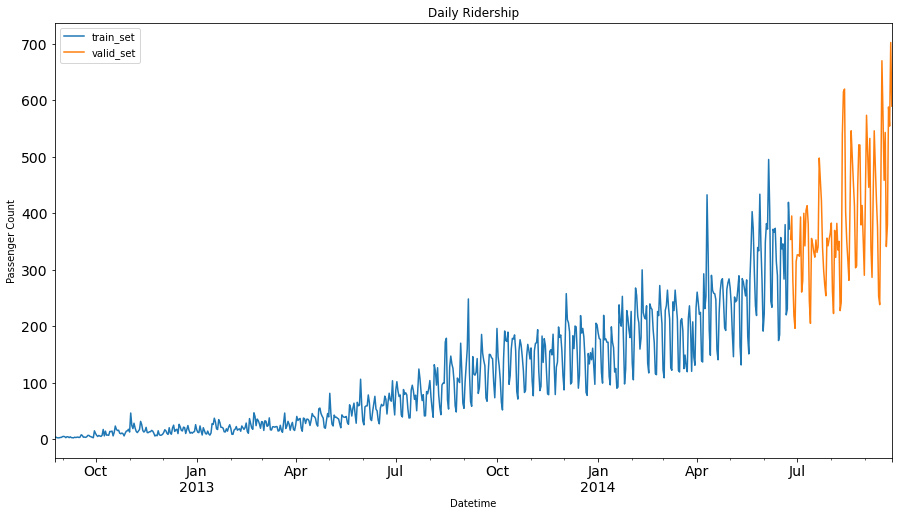

In [15]:
# Visualize the split between the train and validation datasets
train_set["Count"].plot(figsize=(15,8),title="Daily Ridership",fontsize=14,label="train_set")
valid_set["Count"].plot(figsize=(15,8),title="Daily Ridership",fontsize=14,label="valid_set")
plt.xlabel("Datetime")
plt.ylabel("Passenger Count")
plt.legend(loc="best");

## Model Selection

I will look at four different types of models for forecasting:
   1. Naive Approach
   2. Moving Average
   3. Simple Exponential Smoothing 
   4. Holt's Linear Trend Model
    
#### Naive Approach 
>The idea behind the naive method for forecasting is to simply choose the data value from the previous period to estimate the next period. The Naive forecasting method of forecasting is one the easiest of all methods. 

### Moving Average
>Average of time series data (observations equally spaced in time) from several consecutive periods. Called 'moving' because it is continually recomputed as new data becomes available, it progresses by dropping the earliest value and adding the latest value.

Read more: http://www.businessdictionary.com/definition/moving-average.html

### Simple Exponential Smoothing
>Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. In other words, the more recent the observation the higher the associated weight.

### Holt's Linear Trend Model
>Holt extended simple exponential smoothing to allow the forecasting of data with a trend. This method involves a forecast equation and two smoothing equations (one for the level and one for the trend): 


I will go through each approach create a visualization and make a prediction to demonstrate each forecasting model

I am going to use `RMSE` to check the accuracy of the model on the validation dataset.
`RMSE` is the standard deviation of the residuals. Residuals are a measure of how far from the regression line data point are.

Formula used is:
>rmse = sqrt∑i=1N1N(p−a)2

Firstly, Naive Approach

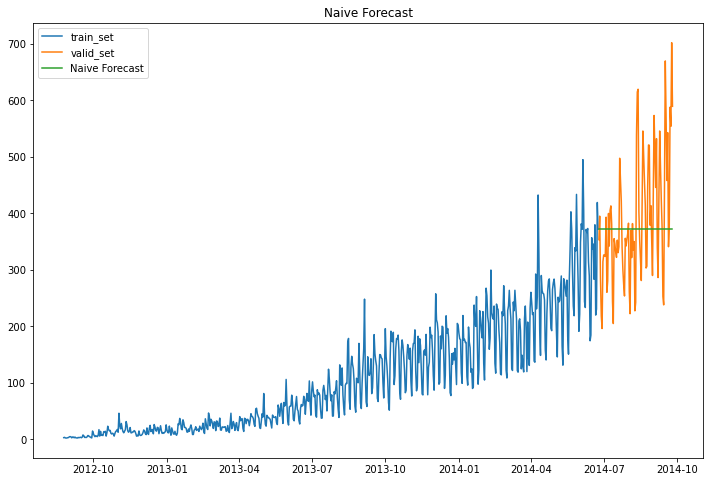

In [17]:
# Visualize the Naive approach
na = np.asarray(train_set["Count"])
y_hat = valid_set.copy()
y_hat["Naive"] = na[len(na)-1]
plt.figure(figsize=(12,8))
plt.plot(train_set.index, train_set["Count"], label="train_set")
plt.plot(valid_set.index, valid_set["Count"], label="valid_set")
plt.plot(y_hat.index, y_hat["Naive"], label="Naive Forecast")
plt.legend(loc="best")
plt.title("Naive Forecast");

In [18]:
# Calculate the accuracy of the Naive Approach Model
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(valid_set["Count"],y_hat["Naive"]))
rms

111.79050467496724

From the score I can infer that this method is not suitable for datasets with high variability

### Secondly, Moving Average Model

I will look at the rolling average for the last 10,20,50 days and visualize the results

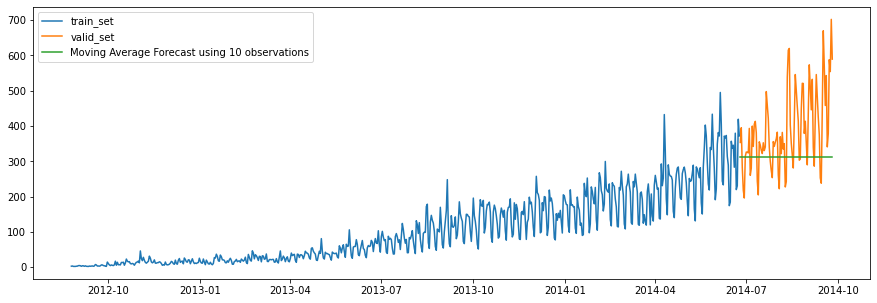

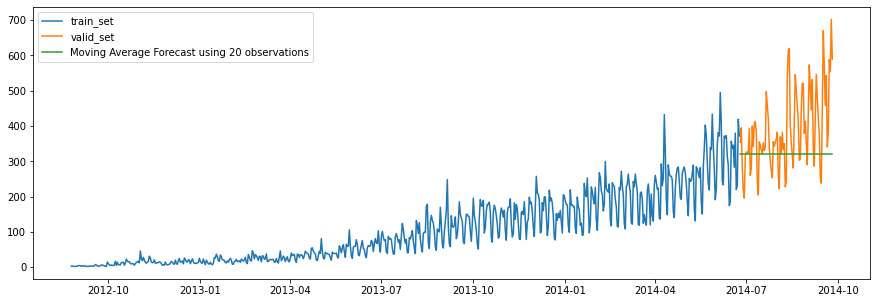

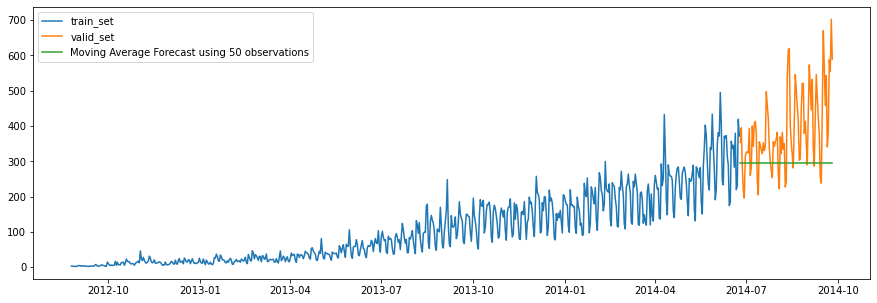

In [19]:
y_hat_avg = valid_set.copy()
y_hat_avg["moving_avg_forecast"] = train_set["Count"].rolling(10).mean().iloc[-1] # average of the last 10 observations

plt.figure(figsize=(15,5))
plt.plot(train_set["Count"], label="train_set")
plt.plot(valid_set["Count"], label="valid_set")
plt.plot(y_hat_avg["moving_avg_forecast"], label="Moving Average Forecast using 10 observations")
plt.legend(loc="best")

y_hat_avg = valid_set.copy()
y_hat_avg["moving_avg_forecast"] = train_set["Count"].rolling(20).mean().iloc[-1] # average of the last 20 observations

plt.figure(figsize=(15,5))
plt.plot(train_set["Count"], label="train_set")
plt.plot(valid_set["Count"], label="valid_set")
plt.plot(y_hat_avg["moving_avg_forecast"], label="Moving Average Forecast using 20 observations")
plt.legend(loc="best")

y_hat_avg = valid_set.copy()
y_hat_avg["moving_avg_forecast"] = train_set["Count"].rolling(50).mean().iloc[-1] # average of the last 50 observations

plt.figure(figsize=(15,5))
plt.plot(train_set["Count"], label="train_set")
plt.plot(valid_set["Count"], label="valid_set")
plt.plot(y_hat_avg["moving_avg_forecast"], label="Moving Average Forecast using 50 observations")
plt.legend(loc="best");

I took the average of of the last 10,20,50 observations and predicted based on that. Can see below the predictions are getting weaker as I increase the number of observations

In [20]:
rms = np.sqrt(mean_squared_error(valid_set["Count"],y_hat_avg["moving_avg_forecast"]))
rms

144.19175679986802

### Simple Exponential Smoothing

The prediction with this model are made by assigning larger weight to more recent values and lesser weight to the old values

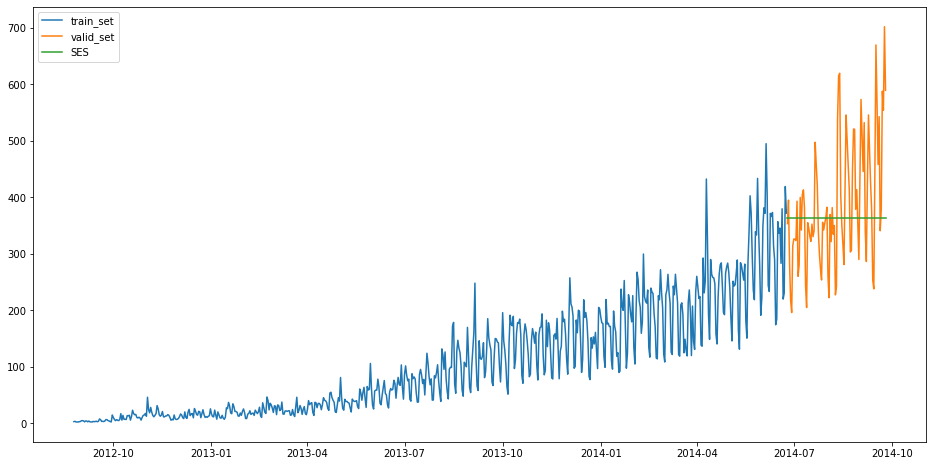

In [21]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

y_hat_avg = valid_set.copy()
fitting = SimpleExpSmoothing(np.asarray(train_set["Count"])).fit(smoothing_level=0.6, optimized=False)
y_hat_avg["SES"] = fitting.forecast(len(valid_set))

plt.figure(figsize=(16,8))
plt.plot(train_set["Count"], label="train_set")
plt.plot(valid_set["Count"], label="valid_set")
plt.plot(y_hat_avg["SES"], label="SES")
plt.legend(loc="best");                                       

In [22]:
rms = np.sqrt(mean_squared_error(valid_set["Count"],y_hat_avg["SES"]))
rms

113.43708111884514

I can infer the fit of this model has improved as the rmse value has reduced.

### Holt's Linear Trend Model

This is an extention of simple exponentail moothing to allow forecasting of data with a trend.
This method takes into account the trend of the dataset. The forecast function in this method is a function of level and trend.

I will split this into four sections:
1. Observed, which is the original time series.
2. Trend, which shows the trend in the time series i.e. increasing or decreasing behaviour of the time series.
3. Seasonal, which tells us about seasonality in the time series.
4. Residual, which is obtained by removing any trend or seasonality in the time series

Let visualize all these parts:

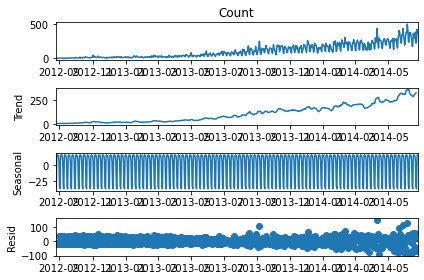

In [23]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train_set["Count"]).plot()
results = sm.tsa.stattools.adfuller(train_set["Count"])

A increasing trend is in the dataset, so I will predict a model based on that trend.

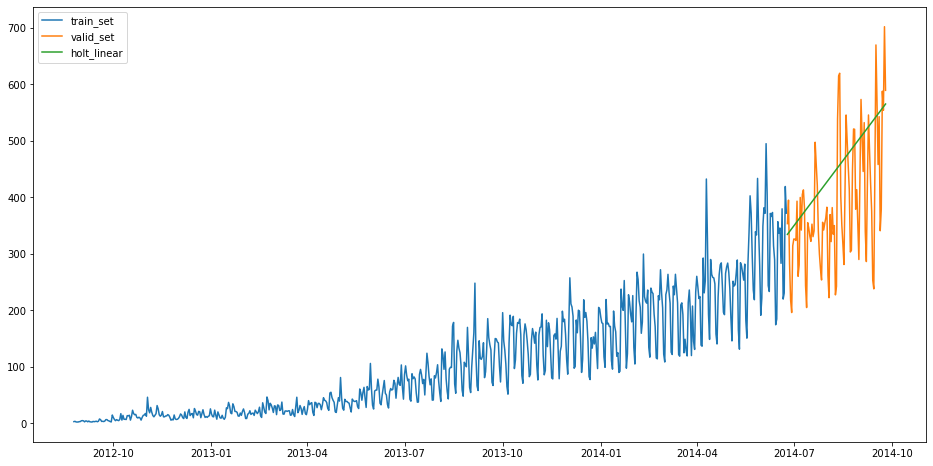

In [24]:
y_hat_avg = valid_set.copy()

fitting_1 = Holt(np.asarray(train_set["Count"])).fit(smoothing_level=0.3, smoothing_slope=0.1)
y_hat_avg["holt_linear"] = fitting_1.forecast(len(valid_set))

plt.figure(figsize=(16,8))
plt.plot(train_set["Count"], label="train_set")
plt.plot(valid_set["Count"], label="valid_set")
plt.plot(y_hat_avg["holt_linear"], label="holt_linear")
plt.legend(loc="best"); 

In [25]:
rms = np.sqrt(mean_squared_error(valid_set["Count"],y_hat_avg["holt_linear"]))
rms

112.94278345314041

Can see again the rmse value has decreased

### I will now make predictions on the test dataset using `Holt's Linear Trend Model`. I will make daily predicitions and distribute this hourly 

In [149]:
# Load the submission file
submission_df = pd.read_csv("data\sample_submission_LSeus50.csv")

In [150]:
submission_df.head()

,ID,Count
0,18288,0
1,18289,0
2,18290,0
3,18291,0
4,18292,0


In [151]:
# Make prediction on the test set 
predict = fitting_1.forecast(len(df_test))

In [152]:
df_test["prediction"]=predict

This is in daily prediction, we need hourly. To do this I will first calculate the ratio of passenger count for each hour every day.
The find the mean ratio of passenger count for every hour and there will be 24 ratios. Then calculate the hourly predictions
I will multiply the daily predictions to the hourly ratio

In [153]:
# Calculate the hourly ratio 
train_original["ratio"] = train_original["Count"]/train_original["Count"].sum()

In [154]:
# Grouping the hourly ratio
temp = train_original.groupby(["hour"])["ratio"].sum()

In [155]:
# Groupby csv format
pd.DataFrame(temp, columns=["hour","ratio"]).to_csv("data/Groupby.csv")

In [156]:
temp_2 = pd.read_csv("data/Groupby.csv")

In [157]:
temp_2 = temp_2.drop("hour.1",1)

In [158]:
# Merge test_df and test_original on day, month and year 
merge = pd.merge(df_test, test_original, on=("day","month","year"), how="left") 
merge["hour"]=merge["hour_y"]
merge = merge.drop(["year","month","Datetime","hour_x","hour_y"], axis=1)

In [159]:
# Predicting by merging merge and temp_2
prediction = pd.merge(merge, temp_2, on="hour", how="left")

In [160]:
# Converting the ratio to the original scale
prediction["Count"] = prediction["prediction"]*prediction["ratio"]*24
prediction["ID"] = prediction["ID_y"]

Drop all features from the submission file and keep ID an count only

In [161]:
submission_df = prediction.drop(["ID_x","day","ID_y","prediction","hour","ratio"],axis=1)

In [162]:
# Converting final submission to csv format
pd.DataFrame(submission_df, columns=["ID","Count"]).to_csv("data/Holt Linear.csv")

### Holt winter's model on daily time series

Dataset which show similar set of pattern after fixed intervals of a time period suffer from seasonailty 

The above mentioned models don’t take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices.

One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind Holt’s Winter is to apply exponential smoothing to the seasonal components in addition to level and trend.

Fit this model on the training data and predict using the validation set

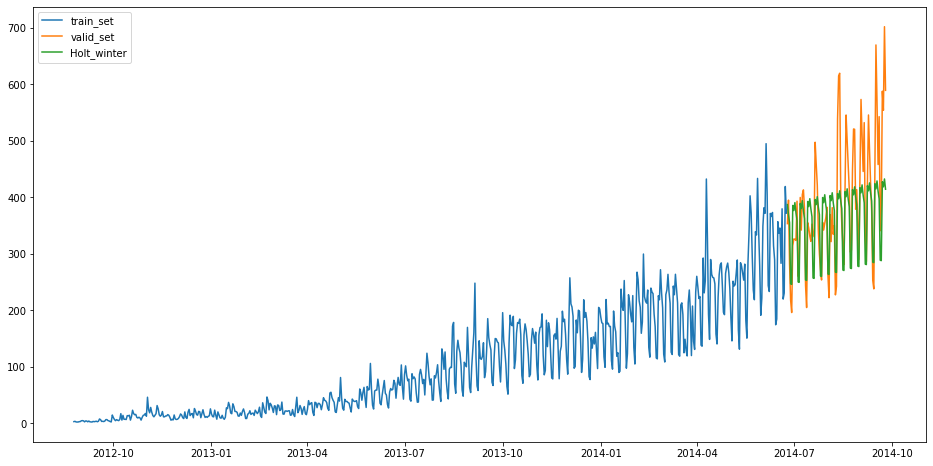

In [39]:
y_hat_avg = valid_set.copy()
fitting_1 = ExponentialSmoothing(np.asarray(train_set["Count"]), seasonal_periods=7, trend="add", seasonal="add",).fit()
y_hat_avg["Holt_winter"] = fitting_1.forecast(len(valid_set))

plt.figure(figsize=(16,8))
plt.plot(train_set["Count"],label="train_set")
plt.plot(valid_set["Count"],label="valid_set")
plt.plot(y_hat_avg["Holt_winter"],label="Holt_winter")
plt.legend(loc="best");

In [40]:
rms = np.sqrt(mean_squared_error(valid_set["Count"], y_hat_avg["Holt_winter"]))
rms

82.37754259011139

## Introduction to ARIMA model

ARIMA( Auto Regression Integrated Moving Average). Is specified by three ordered parameters (p,d,q)

1. p is the order of the autoregressive model(number of lags)
2. d is the degree of differencing(number of times the data have had past values subtracted)
3. q is the order of moving average model. 

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation.

### What is a stationary time series? 

There are three basic criterion for a series to be classified as stationary series :

We make the series stationary to make the variables independent. Variables can be dependent in various ways, but can only be independent in one way. So, we will get more information when they are independent. Hence the time series must be stationary.

If the time series is not stationary, firstly we have to make it stationary. For doing so, we need to remove the trend and seasonality from the data. To learn more about stationarity you can refer this article: https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/


## Stationarity Check

The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

We interpret this result using the Test Statistics and critical value. If the Test Statistics is smaller than critical value, it suggests we reject the null hypothesis (stationary), otherwise a greater Test Statistics suggests we accept the null hypothesis (non-stationary).

Going to make a function which we can use to calculate the results of Dickey-Fuller test.

In [56]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(time_series):
    """
    Determine whether a time series is stationary or not.
    """
    # Determine rolling statistics
    roll_mean = train_original.rolling(24).mean() # 24 hours on each day
    roll_std = train_original.rolling(24).std()
    
    # Perform Dickey-Fuller test
    print("Results of Dickey-Fuller: ")
    df_test = adfuller(time_series, autolag="AIC")
    df_output = pd.Series(df_test[0:4], index=["Test Statistic", "p_value", "#Lag Used", "Number of Observations Used"])
    
    for k, v in df_test[4].items():
        df_output["Critical Value (%s)"%k] = v
    print(df_output)

In [57]:
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 20,10

test_stationary(train_original["Count"])

Results of Dickey-Fuller: 
Test Statistic                    -4.456561
p_value                            0.000235
#Lag Used                         45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


The statistics shows that the time series is stationary as Test Statistic < Critical value but we can see an increasing trend in the data. So, firstly we will try to make the data more stationary. For doing so, we need to remove the trend and seasonality from the data.

## Removing Trend

A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear.

We see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, for example log transformation.

We will take rolling average here to remove the trend. We will take the window size of 24 based on the fact that each day has 24 hours.

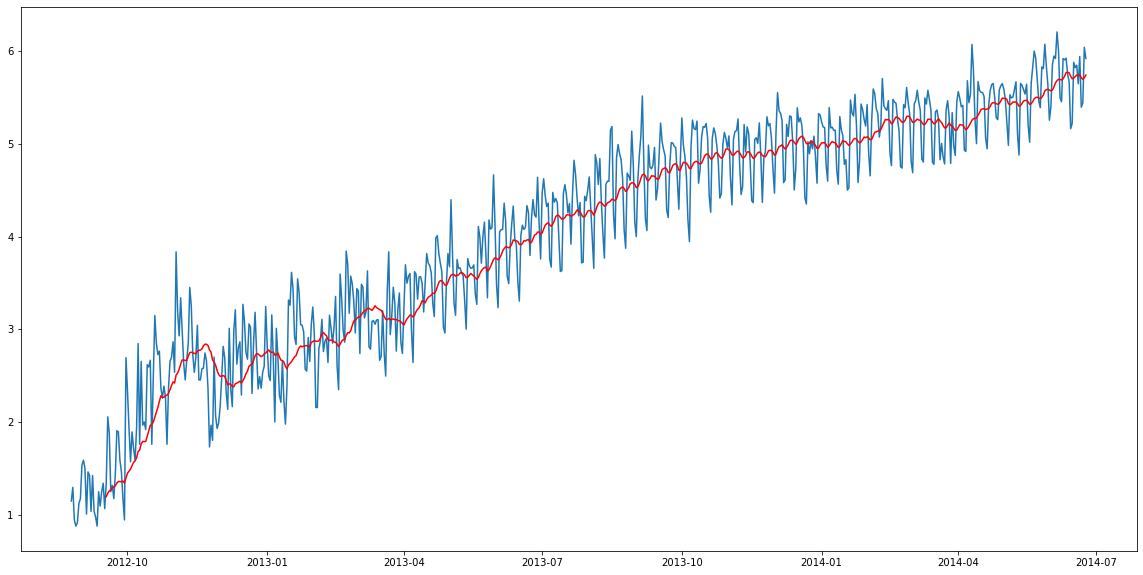

In [63]:
train_log = np.log(train_set["Count"])
valid_log = np.log(valid_set["Count"])

moving_avg = train_log.rolling(24).mean()
plt.plot(train_log)
plt.plot(moving_avg, color="red");

The above shows an increasing trend. I will remove this trend to make the time series more stationary.

In [64]:
train_log_moving_avg_diff = train_log - moving_avg

Since we took the averages of 24 values, rolling mean is not defined for the first 23 values. Therefore, I can drop those null values

In [65]:
train_log_moving_avg_diff

Timestamp
2012-08-25         NaN
2012-08-26         NaN
2012-08-27         NaN
2012-08-28         NaN
2012-08-29         NaN
                ...   
2014-06-20    0.200295
2014-06-21   -0.317381
2014-06-22   -0.253342
2014-06-23    0.326990
2014-06-24    0.179745
Freq: D, Name: Count, Length: 669, dtype: float64

In [66]:
train_log_moving_avg_diff.dropna(inplace=True)
test_stationary(train_log_moving_avg_diff)

Results of Dickey-Fuller: 
Test Statistic                -5.861646e+00
p_value                        3.399422e-07
#Lag Used                      2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


We can see that the Test Statistic is very smaller as compared to the Critical Value. So, we can be confident that the trend is almost removed.

Let’s now stabilize the mean of the time series which is also a requirement for a stationary time series.

Differencing can help to make the series stable and eliminate the trend.

In [79]:
train_log_diff = train_log - train_log.shift(1)
test_stationary(train_log_diff.dropna())

Results of Dickey-Fuller: 
Test Statistic                -8.237568e+00
p_value                        5.834049e-13
#Lag Used                      1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


## Removing Seasonality 

By seasonality, we mean periodic fluctuations. A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week).

Seasonality is always of a fixed and known period.

We will use seasonal decompose to decompose the time series into trend, seasonality and residuals.

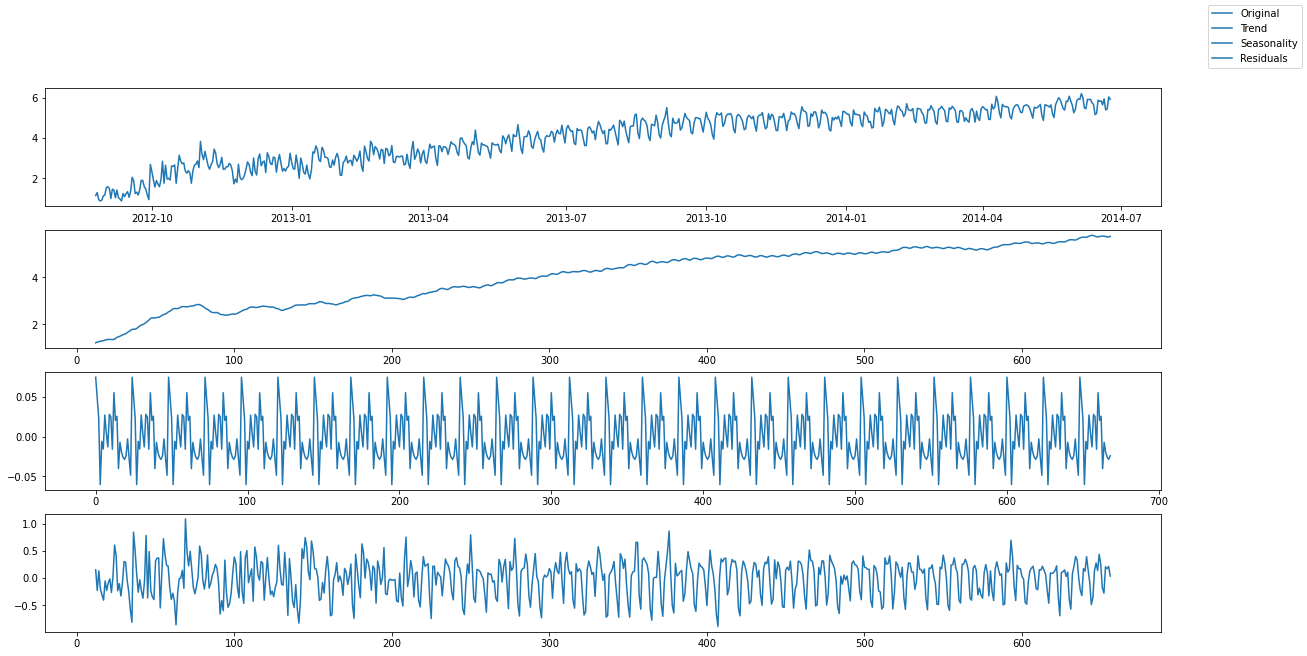

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(pd.DataFrame(train_log)["Count"].values, period = 24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4,
                                         ncols=1)

ax0.plot(train_log, label="Original")
ax1.plot(trend, label="Trend")
ax2.plot(seasonal, label="Seasonality")
ax3.plot(residual, label="Residuals")
fig.legend();

Can see the trend, residuals and the seasonality in the graph above. Seasonality shows a constant trend in the counter

In [75]:
# Checking the stationarity of residuals
train_log_decompose = pd.DataFrame(residual)
train_log_decompose["date"] = train_log.index
train_log_decompose.set_index("date", inplace=True)
train_log_decompose.dropna(inplace=True)
test_stationary(train_log_decompose[0])

Results of Dickey-Fuller: 
Test Statistic                -7.822096e+00
p_value                        6.628321e-12
#Lag Used                      2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


It can be interpreted from the results that the residuals are stationary.

Now we will forecast the time series using different models.

## Forecasting the time series using ARIMA

First of all we will fit the ARIMA model on our time series for that we have to find the optimized values for the p,d,q parameters.

To find the optimized values of these parameters, we will use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.

ACF is a measure of the correlation between the TimeSeries with a lagged version of itself.

PACF measures the correlation between the TimeSeries with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In [80]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(train_log_diff.dropna(), nlags=25)
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method="ols")

C:\Users\husho\Intro-to-Python-for-Data-Science\time-series-predicition\env\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


### ACF & PACF Plot

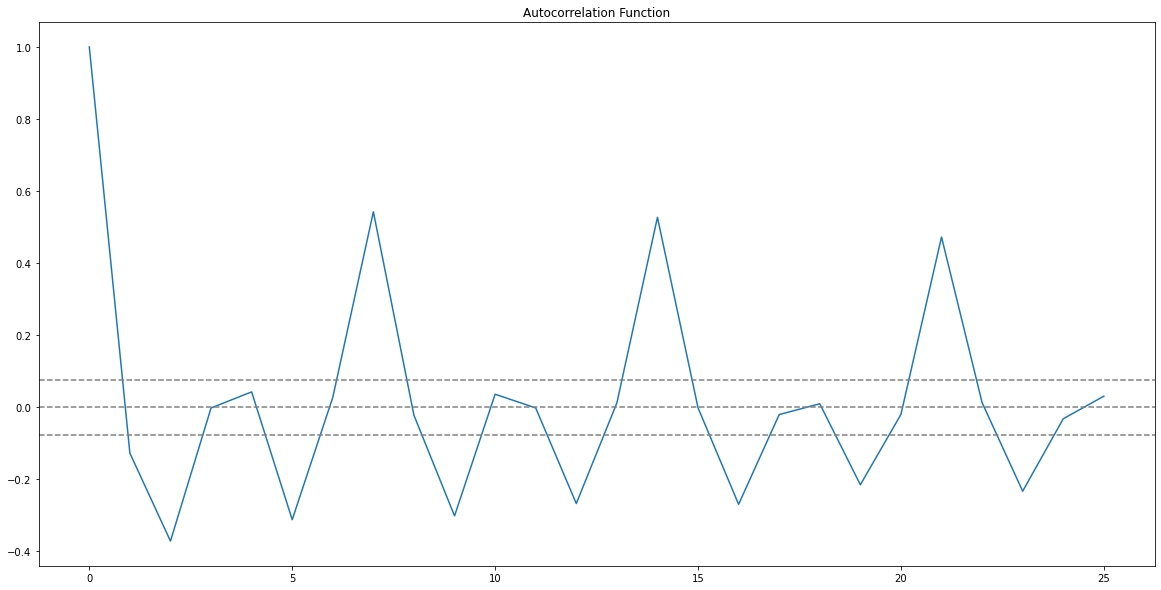

In [95]:
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Autocorrelation Function') ;

Text(0.5, 1.0, 'Partial Autocorrelation Function')

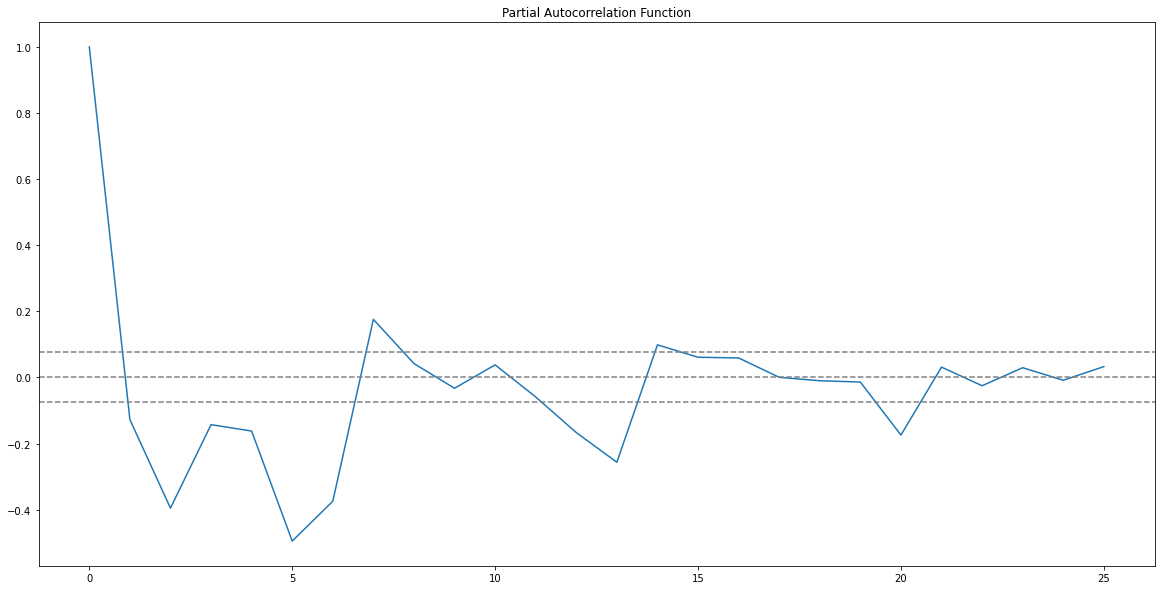

In [96]:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 

p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=1.

q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=1.

Now we will make the ARIMA model as we have the p,q values. We will make the AR and MA model separately and then combine them together.

## AR Model

The autoregressive model specifies that the output variable depends linearly on its own previous values.

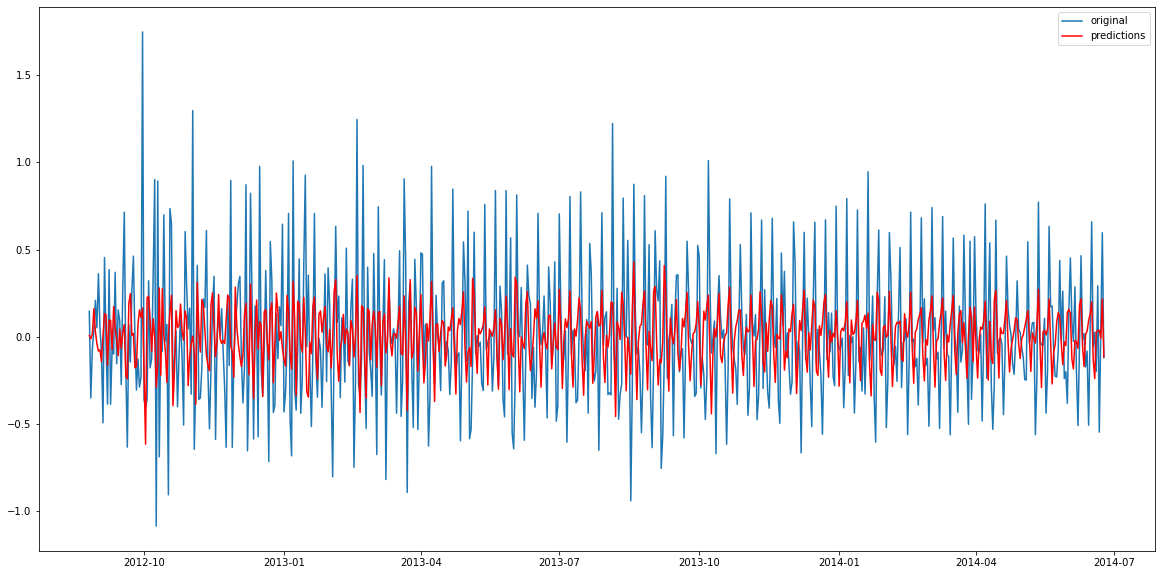

In [98]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_log, order=(2, 1, 0)) # The q value is 0 since it is just the AR model
results_ar = model.fit(disp=-1)
plt.plot(train_log_diff.dropna(), label="original")
plt.plot(results_ar.fittedvalues, color="red", label="predictions")
plt.legend(loc="best");

Plot the validation curve for AR Model

To do this I need to change the scale of the model to the original scale

Firstly, store the predicted results as a separate series and observe it

In [101]:
AR_predict=results_ar.predict(start="2014-06-25", end="2014-09-25") 
AR_predict=AR_predict.cumsum().shift().fillna(0) 
AR_predict1=pd.Series(np.ones(valid_set.shape[0]) * np.log(valid_set['Count'])[0], index = valid_set.index) 
AR_predict1=AR_predict1.add(AR_predict,fill_value=0) 
AR_predict = np.exp(AR_predict1)

Text(0.5, 1.0, 'RMSE: 43.9740')

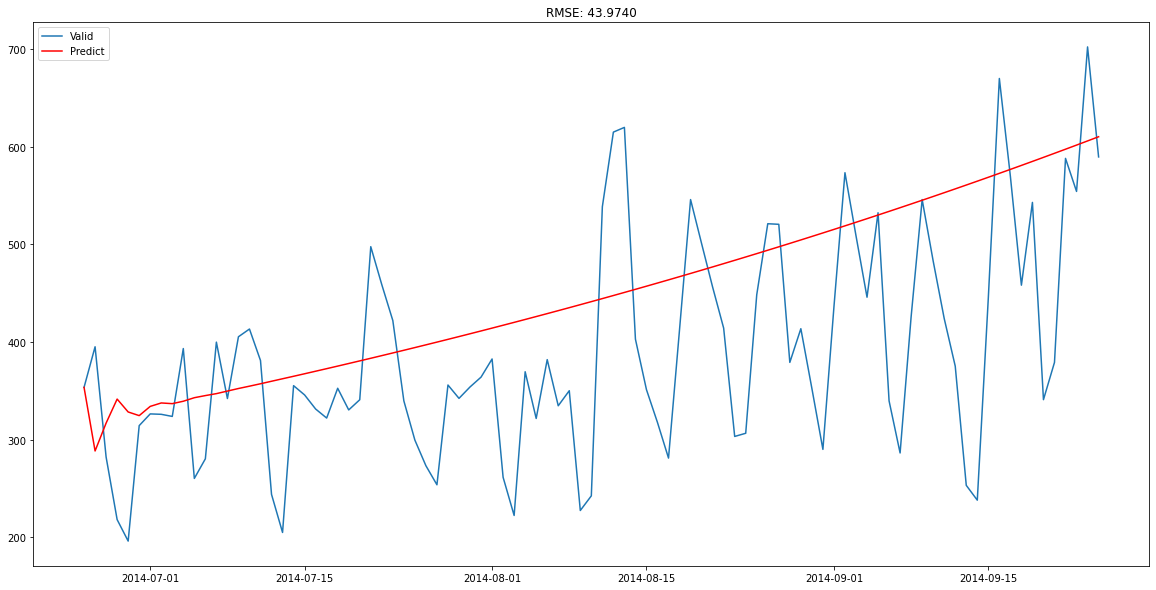

In [102]:
plt.plot(valid_set['Count'], label = "Valid") 
plt.plot(AR_predict, color = 'red', label = "Predict") 
plt.legend(loc='best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid_set['Count']))/valid_set.shape[0]))

Here the red line shows the prediction for the validation set. Let’s build the MA model now.

## MA Model 

The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.

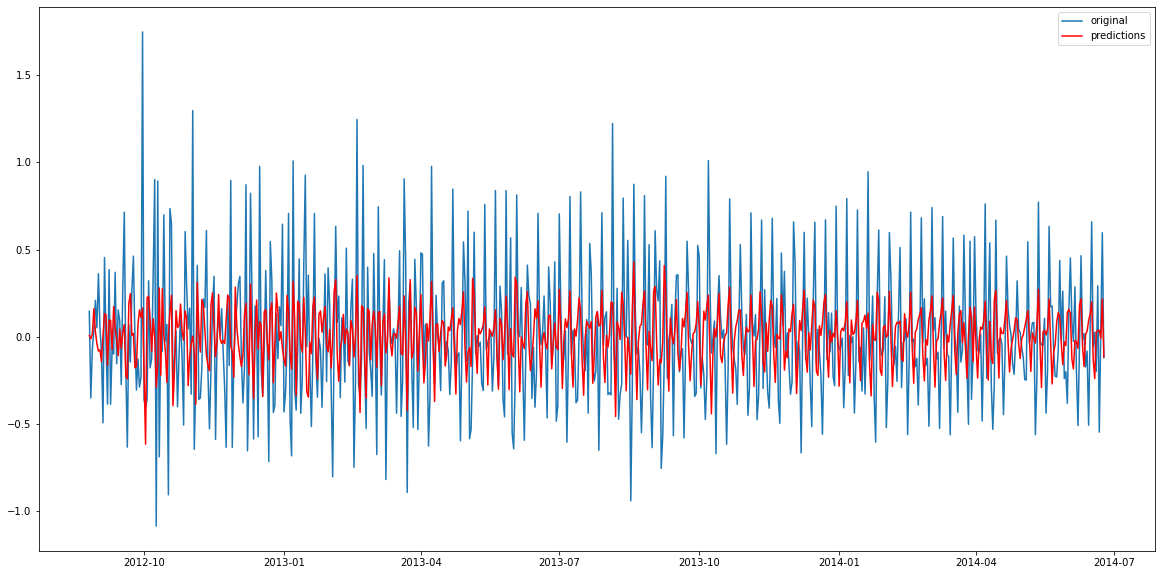

In [103]:
model = ARIMA(train_log, order=(2, 1, 0)) # The q value is 0 since it is just the MA model
results_ma = model.fit(disp=-1)
plt.plot(train_log_diff.dropna(), label="original")
plt.plot(results_ma.fittedvalues, color="red", label="predictions")
plt.legend(loc="best");

In [108]:
MA_predict=results_ma.predict(start="2014-06-25", end="2014-09-25")
MA_predict=MA_predict.cumsum().shift().fillna(0) 
MA_predict1=pd.Series(np.ones(valid_set.shape[0]) * np.log(valid_set['Count'])[0], index = valid_set.index) 
MA_predict1=MA_predict1.add(MA_predict,fill_value=0) 
MA_predict = np.exp(MA_predict1)

Text(0.5, 1.0, 'RMSE: 43.9740')

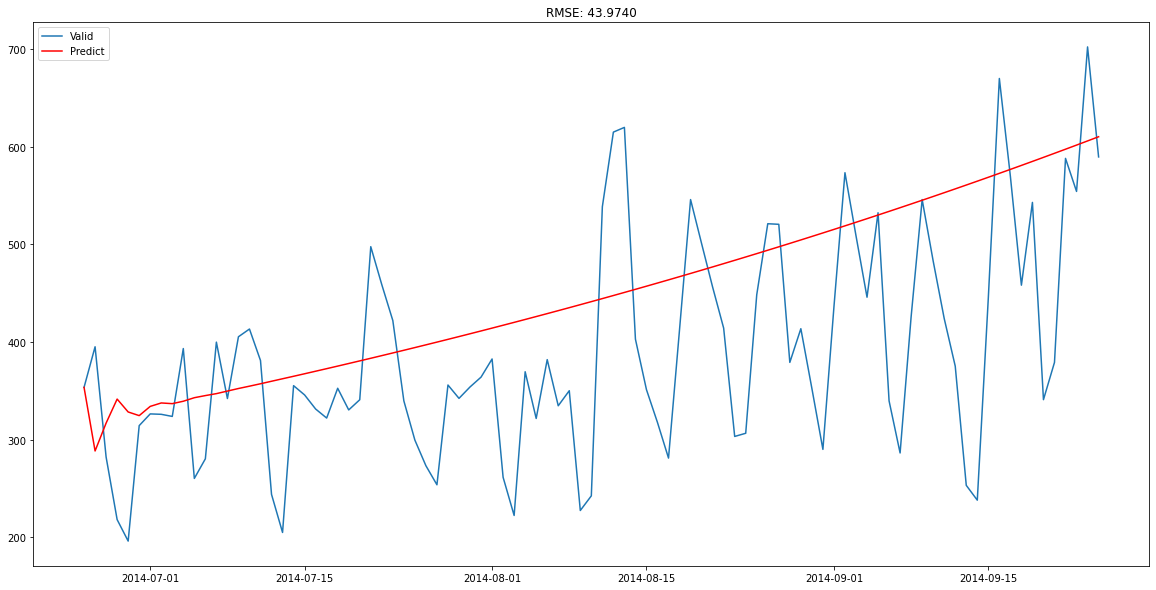

In [110]:
plt.plot(valid_set['Count'], label = "Valid") 
plt.plot(MA_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid_set['Count']))/valid_set.shape[0])) 

Now I will combine the two models

## Combined Models

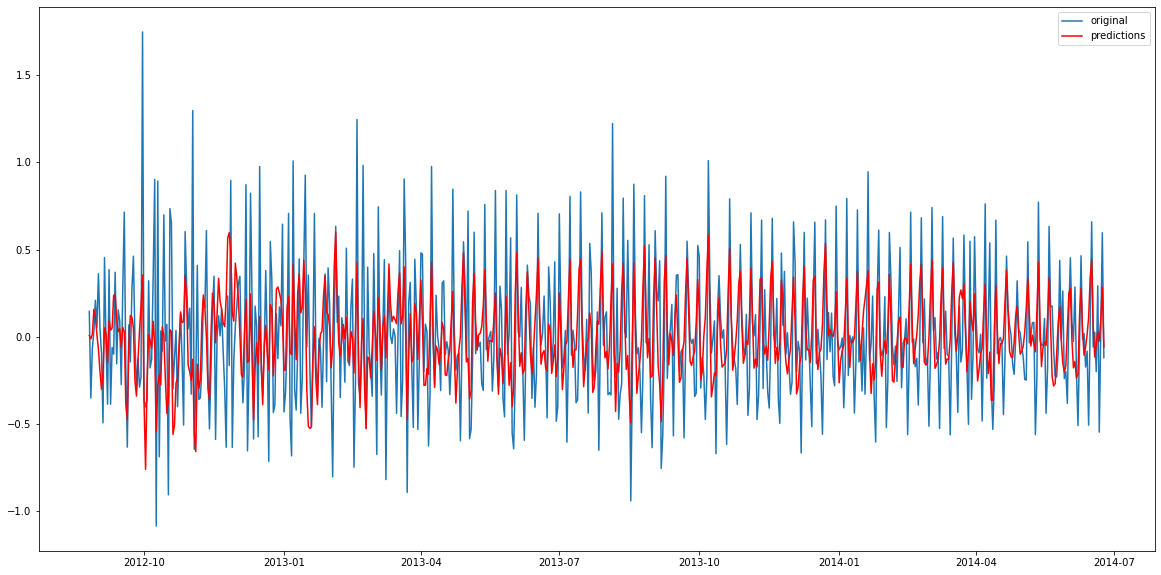

In [113]:
model = ARIMA(train_log, order=(2, 1, 2)) 
results_ARIMA = model.fit(disp=-1)
plt.plot(train_log_diff.dropna(), label="original")
plt.plot(results_ARIMA.fittedvalues, color="red", label="predictions")
plt.legend(loc="best");

Define a function which can be used to change the scale of the model to the original scale.

In [114]:
def check_prediction_diff(predict_diff, given_set):
    
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc='best')

In [115]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc='best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))

Predict the values for the validation set 

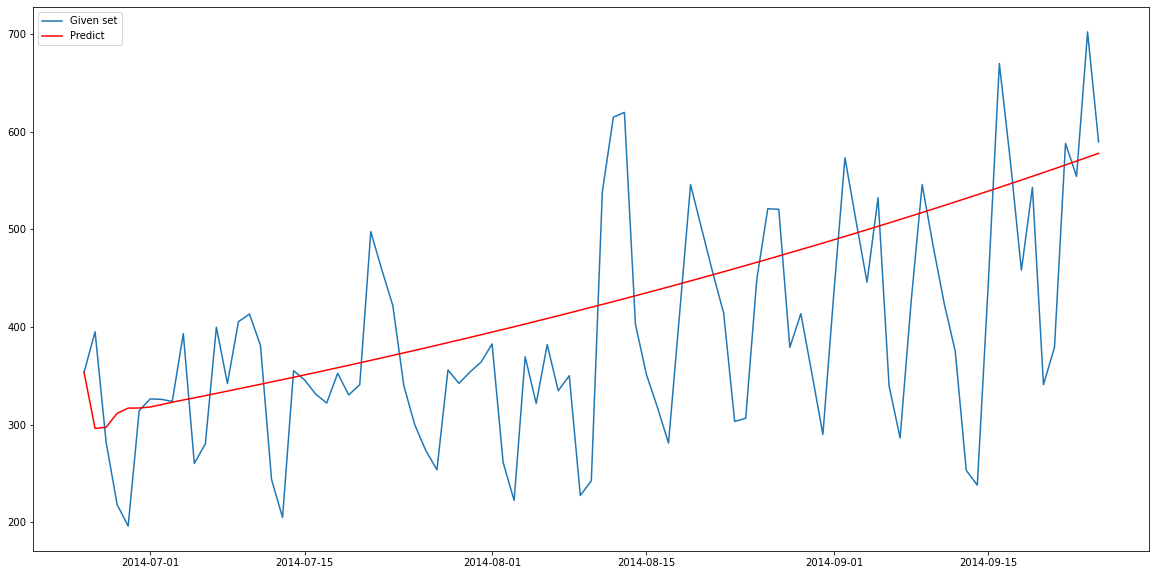

In [116]:
ARIMA_predict_diff = results_ARIMA.predict(start="2014-06-25", end="2014-09-25")
 
check_prediction_diff(ARIMA_predict_diff, valid_set)

## SARIMAX Model on daily time series

SARIMAX Model takes into account the seasonality of the time series. So I will build a SARIMAX Model on time series.

C:\Users\husho\Intro-to-Python-for-Data-Science\time-series-predicition\env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


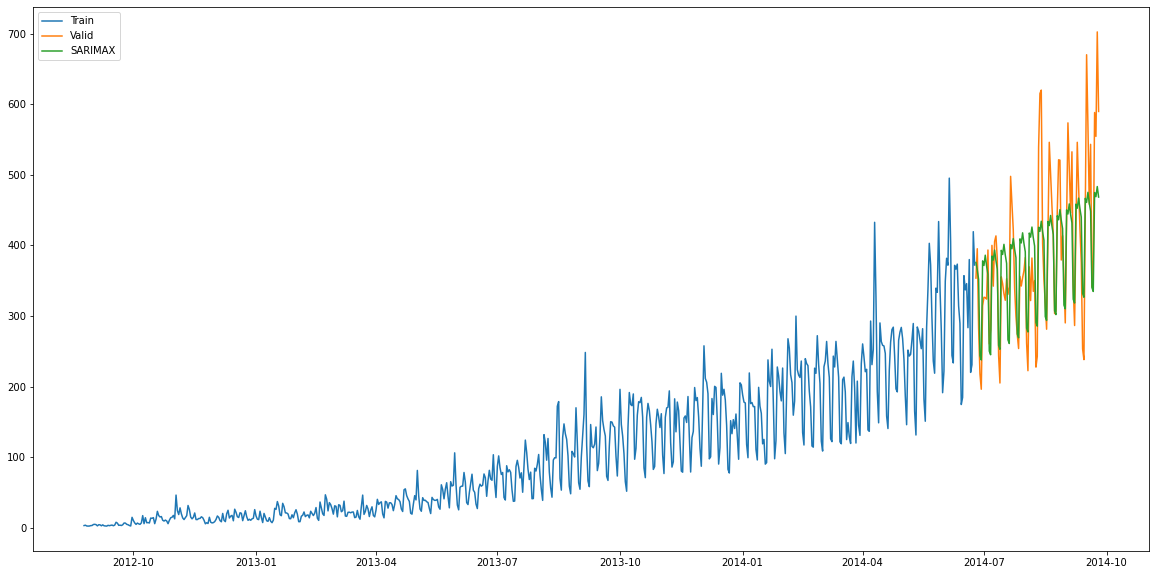

In [118]:
import statsmodels.api  as sm

y_hat_avg = valid_set.copy()
fitting1 = sm.tsa.statespace.SARIMAX(train_set["Count"], order=(2,1,4), seasonal_order=(0,1,1,7)).fit()

y_hat_avg["SARIMAX"] = fitting1.predict(start="2014-06-25", end="2014-09-25", dynamic=True)

plt.plot(train_set["Count"], label="Train")
plt.plot(valid_set["Count"], label="Valid")
plt.plot(y_hat_avg["SARIMAX"], label="SARIMAX")
plt.legend(loc="best");

Order in the above model represents the order of the autoregressive model(number of time lags), the degree of differencing(number of times the data have had past values subtracted) and the order of moving average model.

Seasonal order represents the order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.

In this case the periodicity is 7 since it is daily time series and will repeat after every 7 days.

In [119]:
# View the RMSE for the valdation part.
rms = np.sqrt(mean_squared_error(valid_set["Count"], y_hat_avg["SARIMAX"]))
rms

69.50770193305463

Now I will forecast the time series for Test data which starts from 2014-9-26 and ends at 2015-4-26.

In [121]:
predict=fitting1.predict(start="2014-9-26", end="2015-4-26", dynamic=True)

C:\Users\husho\Intro-to-Python-for-Data-Science\time-series-predicition\env\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2012: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Note that these are the daily predictions and we need hourly predictions. So, we will distribute this daily prediction into hourly counts. To do so, we will take the ratio of hourly distribution of passenger count from train data and then we will distribute the predictions in the same ratio.

In [174]:
df_test['prediction']=predict

In [175]:
# Merge test_df and test_original on day, month and year 
merge = pd.merge(df_test, test_original, on=("day","month","year"), how="left") 
merge["hour"]=merge["hour_y"]
merge = merge.drop(["year","month","Datetime","hour_x","hour_y"], axis=1)

In [176]:
# Predicting by merging merge and temp_2
prediction = pd.merge(merge, temp_2, on="hour", how="left")

In [177]:
# Converting the ratio to the original scale
prediction["Count"] = prediction["prediction"]*prediction["ratio"]*24

In [179]:
# Drop other values other that ID and Count
prediction['ID']=prediction['ID_y'] 
submission=prediction.drop(['day','hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1) 

In [180]:
# Converting the final submission to csv format 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('SARIMAX.csv')

In [181]:
submission

,Count,ID
0,411.715994,18288
1,328.570903,18289
2,278.072186,18290
3,229.761113,18291
4,193.390623,18292
...,...,...
5107,614.610872,23395
5108,590.619822,23396
5109,551.281109,23397
5110,553.281088,23398
